In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm.notebook import tqdm
import pickle
import wandb
from torch.utils.data import random_split
import matplotlib.pyplot as plt

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
!gdown https://drive.google.com/uc?id=1xuQkW1U3jAQ_OcoJZ53to3rdyhDhxS-f
!gdown https://drive.google.com/uc?id=1SgI0iByWuAUGm928lY_3bpwFf8C8HKvc


Downloading...
From: https://drive.google.com/uc?id=1xuQkW1U3jAQ_OcoJZ53to3rdyhDhxS-f
To: /content/CrimeData
100% 15.5M/15.5M [00:00<00:00, 213MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SgI0iByWuAUGm928lY_3bpwFf8C8HKvc
To: /content/Debug
100% 320k/320k [00:00<00:00, 86.0MB/s]


In [ ]:
#Data + Preprocessing

debug_file = 'Debug'
full_file = 'CrimeData'

with open(debug_file, 'rb') as file:
    debug_data = pickle.load(file)

with open(full_file, 'rb') as file:
    full_data = pickle.load(file)

debug = False # Set true to run on debug data

def preprocess_data(df):
    # Parse datetime features
    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour
    df['day_of_week'] = df['date'].dt.dayofweek

    # One-hot encode hour and day_of_week
    hour_onehot = pd.get_dummies(df['hour'], prefix='hour', dtype=int)
    day_onehot = pd.get_dummies(df['day_of_week'], prefix='day', dtype=int)

    # Normalize latitude and longitude
    scaler = StandardScaler()
    df[['latitude', 'longitude']] = scaler.fit_transform(df[['latitude', 'longitude']])

    # Encode categorical features
    location_encoder = LabelEncoder()
    df['location_description'] = location_encoder.fit_transform(df['location_description'])

    # Encode target variable
    target_encoder = LabelEncoder()
    df['primary_type'] = target_encoder.fit_transform(df['primary_type'])

    # Combine all features
    features = pd.concat([
        df[['latitude', 'longitude', 'location_description', 'arrest', 'domestic']],
        hour_onehot, day_onehot
    ], axis=1)

    return features.astype(float), df['primary_type'], target_encoder

features, labels, target_encoder = preprocess_data(debug_data if debug else full_data)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

batch_size = 64  # Adjust batch size as needed

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(X_train.shape, X_test.shape)

torch.Size([44144, 1, 36]) torch.Size([4905, 1, 36])


In [ ]:
#model definition + training

class CrimeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, activation='ReLU', dropout=0.5, batchNorm=None):
        super(CrimeLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        if batchNorm:
            self.batchNorm = nn.BatchNorm1d(hidden_size)
        else:
            self.batchNorm = nn.Identity()

        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.act = getattr(nn, activation)()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc1(out[:, -1, :])  # Take the last output of the LSTM
        out = self.batchNorm(out)
        out = self.act(out)
        out = self.fc2(out)  # Take the last output of the LSTM

        return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Use GPU when available
input_size = X_train.shape[2]  # Number of features
hidden_size = 128 # Hidden Size
num_classes = len(target_encoder.classes_) # Input feature size
model = CrimeLSTM(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss() # Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0066312) # Optimizer
num_epochs = 10 # Epochs
model.to(device)

CrimeLSTM(
  (lstm): LSTM(36, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (batchNorm): Identity()
  (fc2): Linear(in_features=128, out_features=30, bias=True)
  (act): ReLU()
)

In [ ]:
def train(
        model,
        criterion,
        optimizer,
        train_loader,
        test_loader,
        num_epochs
):
    ret_train, ret_val = [], []
    for epoch in range(num_epochs):
      model.train()
      y_pred_train = []
      y_true_train = []
      train_loss = 0
      for X_batch, y_batch in tqdm(train_loader, leave=False):
          X_batch, y_batch = X_batch.to(device), y_batch.to(device)

          # Forward pass
          outputs = model(X_batch)
          loss = criterion(outputs, y_batch)

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          with torch.no_grad():
              _, predicted = torch.max(outputs.detach(), 1)
              y_pred_train.extend(predicted.cpu().numpy())
              y_true_train.extend(y_batch.cpu().numpy())


          train_loss += loss.item()

      model.eval()
      y_pred_val = []
      y_true_val = []

      with torch.no_grad():
          for X_batch, y_batch in test_loader:
              X_batch, y_batch = X_batch.to(device), y_batch.to(device)
              outputs = model(X_batch)
              _, predicted = torch.max(outputs, 1)

              y_pred_val.extend(predicted.cpu().numpy())
              y_true_val.extend(y_batch.cpu().numpy())

      # Calculate accuracy
      val_accuracy = accuracy_score(y_true_val, y_pred_val)
      train_accuracy = accuracy_score(y_true_train, y_pred_train)
      ret_train.append(train_accuracy)
      ret_val.append(val_accuracy)

      print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, 'Val Accuracy: {val_accuracy:.4f}")

    return ret_train, ret_val

train(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    10
)

  0%|          | 0/690 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1558, Train Accuracy: 0.3126, 'Val Accuracy: 0.3246


  0%|          | 0/690 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0556, Train Accuracy: 0.3319, 'Val Accuracy: 0.3305


  0%|          | 0/690 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0352, Train Accuracy: 0.3381, 'Val Accuracy: 0.3254


  0%|          | 0/690 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0262, Train Accuracy: 0.3396, 'Val Accuracy: 0.3331


  0%|          | 0/690 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0126, Train Accuracy: 0.3438, 'Val Accuracy: 0.3360


  0%|          | 0/690 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0027, Train Accuracy: 0.3457, 'Val Accuracy: 0.3431


  0%|          | 0/690 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9884, Train Accuracy: 0.3486, 'Val Accuracy: 0.3354


  0%|          | 0/690 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9787, Train Accuracy: 0.3489, 'Val Accuracy: 0.3407


  0%|          | 0/690 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9745, Train Accuracy: 0.3529, 'Val Accuracy: 0.3439


  0%|          | 0/690 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9682, Train Accuracy: 0.3539, 'Val Accuracy: 0.3325


([0.31261326567596953,
  0.33186843059079374,
  0.3380527364987314,
  0.33957049655672344,
  0.34376132656759695,
  0.34570949619427327,
  0.3486317506342878,
  0.3489035882566147,
  0.3528678869155491,
  0.3539325842696629],
 [0.32456676860346584,
  0.33047910295616717,
  0.3253822629969419,
  0.33312945973496433,
  0.3359836901121305,
  0.3431192660550459,
  0.33537206931702346,
  0.3406727828746177,
  0.3439347604485219,
  0.3325178389398573])

In [ ]:
def model_predict(X):
    X_tensor = torch.tensor(X.reshape(X.shape[0], 1, -1), dtype=torch.float32).to(device)
    with torch.no_grad():
        outputs = model(X_tensor)
        _, predicted = torch.max(outputs, 1)
    return predicted.cpu().numpy()

In [ ]:
!pip install shap

In [ ]:
import shap
X_train_sample = next(iter(train_loader))[0][:].cpu().numpy()
X_test_sample = next(iter(test_loader))[0][:].cpu().numpy()
print(X_train_sample.shape)
print(X_test_sample.shape)
X_train_sample_flattened = X_train_sample.reshape(X_train_sample.shape[0], -1)
X_test_sample_flattened = X_test_sample.reshape(X_test_sample.shape[0], -1)
print(X_train_sample_flattened.shape)
print(X_test_sample_flattened.shape)

(64, 1, 36)
(64, 1, 36)
(64, 36)
(64, 36)


In [ ]:
explainer = shap.KernelExplainer(model_predict, X_train_sample_flattened)
shap_values = explainer.shap_values(X_test_sample_flattened)

  0%|          | 0/64 [00:00<?, ?it/s]

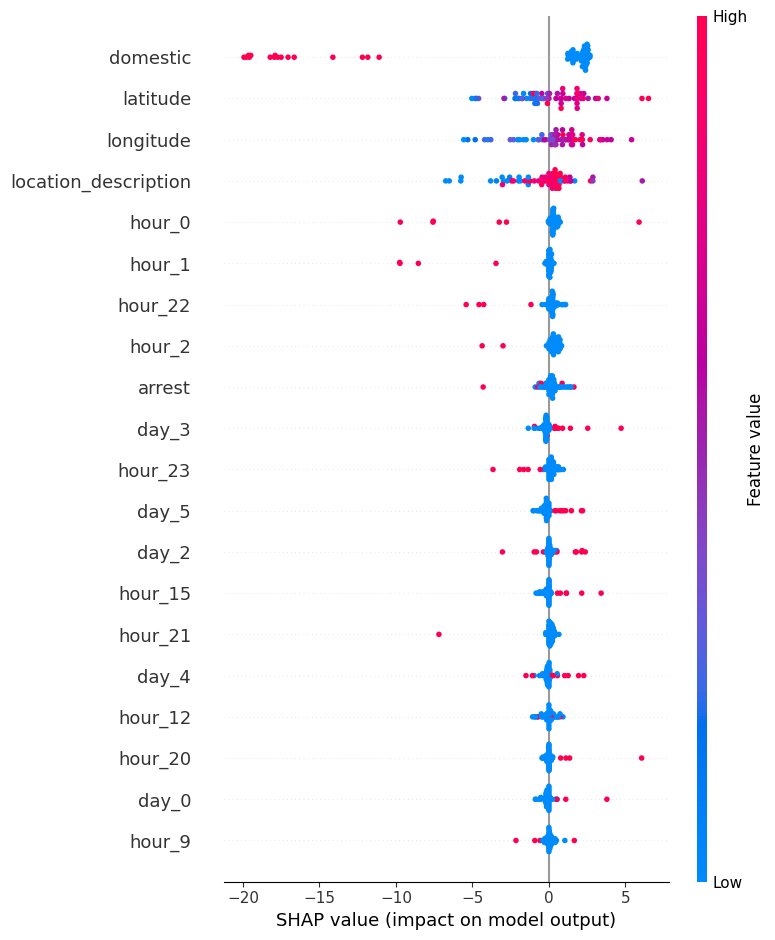

In [ ]:
sequence_length = X_test_sample.shape[1]
num_features = X_test_sample.shape[2]

#mild preprocessing to re-obtain hour/day_onehot
df = debug_data if debug else full_data
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek

# One-hot encode hour and day_of_week
hour_onehot = pd.get_dummies(df['hour'], prefix='hour', dtype=int)
day_onehot = pd.get_dummies(df['day_of_week'], prefix='day', dtype=int)

feature_names = (
        ['latitude', 'longitude', 'location_description', 'arrest', 'domestic'] +
        list(hour_onehot.columns) +
        list(day_onehot.columns)
    )

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_test_sample_flattened, feature_names=feature_names)

## Discussion

Here we can see a Shapley plot for our features, organized by importance. Here are some notable points, and what they can mean for our model performance.

- The most important feature is the domestic category, which specifies if a crime falls under domestic violence. This is clearly very helpful as certain crimes (assault, battery), are far likelier in these cases than others. Additionally, crimes like trespassing and fraud are simply not possible in a domestic crime.

- Latitude and longitude were also considered very important, which also makes sense. Certain kinds of crime like theft or robbery may be likelier in areas with expensive material possessions (Jeweler's Row, shopping districts, etc). Additionally, certain crimes like trespassing may be heavily monitored at certain areas (like government buildings), meaning that these offenses are likelier to be found out and therefore added to the data.

- As we can see, the specific one-hot encodings for hours/days meant that each was treated as an individual feature, showing relative importance between hours/days more than overall importance compared to other features. However, we see a bias toward hours of the late night/early morning. These are likely more important features as there is more data/crimes at these times and that your more serious crimes tend to be clustered at these times, providing opportunity for predictive capability.

- Days of the week did not seem to provide much immediately explainable information, but weekdays seemed to be considered more important, which might be suggesting that the model was able to rule out certain crimes (or consider them less likely) during weekdays.